<img src="flopylogo.png" style="float: left">

#Problem P4.1 Flopy Background and Toth (1962) Flow System

Flopy is a set of python scripts for writing MODFLOW data sets and reading MODFLOW binary output files.  Flopy Version 3 is served from Github and can be accessed [here](https://github.com/modflowpy/flopy "Flopy Website").  Previous versions of flopy were served from google code, however, they are no longer supported.

Some things to keep in mind:
* Flopy is still in development.  It works for many MODFLOW packages.  It also  works for MT3DMS and SEAWAT.  Some package options, and some packages, however, are not supported yet.
* Flopy is primarily a writer and reader of MODFLOW data sets.  It does not intersect grids with spatial features, or perform time series interpolation.  It is up to the user to do this.  As part of this class, we will show how this can be done within the Python environment.
* Preliminary documentation for Flopy can be accessed [here](http://modflowpy.github.io/flopydoc/ "Flopy Documentation").

In this notebook, we will work through one tutorial based on the Toth (1962). We simpflied it to look like this:

<img src="P4.1_figure.tiff" style="float: center">


Below is an iPython Notebook that builds a MODFLOW model of the Toth (1962) flow system and plots results. See the Github wiki associated with this Chapter for information on one suggested installation and setup configuration for Python and iPython Notebook.

[Acknowledgements: This tutorial has benefited greatly from the online Flopy tutorial and example notebooks developed by Chris Langevin and Joe Hughes for the USGS Spring 2015 Python Training course GW1774]

##Flopy Tutorial 1: Creating the Model
In this example, we will create a simple groundwater flow model by following the tutorial included on the Flopy website.  We will make a few small changes  so that the tutorial works with our file structure.

Visit the tutorial website [here](http://modflowpy.github.io/flopydoc/tutorial1.html "tutorial").

###Setup the Notebook Environment and Import Flopy
Load a few standard libraries, and then load flopy.

In [1]:
%matplotlib inline
import sys
import os
import shutil
import numpy as np
from subprocess import check_output

# Import class paths
#from paths import *

# Import flopy
import flopy

###Setup a New Directory and Change Paths
For this tutorial, we will work in the 21_FlopyIntro directory, which is located up one folder and over to the Data folder.  We can use some fancy Python tools to help us manage the directory creation.  Note that if you encounter path problems with this workbook, you can stop and then restart the kernel and the paths will be reset.

In [2]:
# Set the name of the path to the model working directory
dirname = "P4-1_Toth"
datapath = os.getcwd()
modelpath = os.path.join(datapath, dirname)
print 'Name of model path: ', modelpath

# Now let's check if this directory exists.  If not, then we will create it.
if os.path.exists(modelpath):
    print 'Model working directory already exists.'
else:
    print 'Creating model working directory.'
    os.mkdir(modelpath)

Name of model path:  /Users/rjhunt1/GitHub/Chapter_4_problems-1/P4-1_Toth
Model working directory already exists.


###Define the Model Extent, Grid Resolution, and Characteristics
It is normally good practice to group things that you might want to change into a single code block.  This makes it easier to make changes and rerun the code.

In [3]:
# model domain and grid definition
# for clarity, user entered variables are all caps; python syntax are lower case or mixed case
# we will use a layer orientation profile for easy plotting (see Box 4.2 on page 126)
LX = 200.
LY = 100.
ZTOP = 1.  # the "thickness" of the profile will be 1 m (= ZTOP - ZBOT)
ZBOT = 0.
NLAY = 1
NROW = 5
NCOL = 10
DELR = LX / NCOL  # recall that MODFLOW convention is DELR is along a row, thus has items = NCOL; see page XXX in AW&H (2015)
DELC = LY / NROW  # recall that MODFLOW convention is DELC is along a column, thus has items = NROW; see page XXX in AW&H (2015)
DELV = (ZTOP - ZBOT) / NLAY
BOTM = np.linspace(ZTOP, ZBOT, NLAY + 1)
HK = 10.
VKA = 1.
print "DELR =", DELR, "  DELC =", DELC, '  DELV =', DELV
print "BOTM =", BOTM


DELR = 20.0   DELC = 20.0   DELV = 1.0
BOTM = [ 1.  0.]


###Create the MODFLOW Model Object
Create a flopy MODFLOW object: [flopy.modflow.Modflow](http://modflowpy.github.io/flopydoc/mf.html).

In [5]:
# Assign name and create modflow model object
modelname = 'P4-1'
exe_name = os.path.join(datapath, 'mf2005')
print 'Model executable: ', exe_name
MF = flopy.modflow.Modflow(modelname, exe_name=exe_name, model_ws=modelpath)

Model executable:  /Users/rjhunt1/GitHub/Chapter_4_problems-1/mf2005


###Discretization Package
Create a flopy discretization package object: [flopy.modflow.ModflowDis](http://modflowpy.github.io/flopydoc/mfdis.html).

In [6]:
# Create the discretization object
TOP = np.ones((NROW, NCOL),dtype=np.float)

In [7]:
DIS_PACKAGE = flopy.modflow.ModflowDis(MF, NLAY, NROW, NCOL, delr=DELR, delc=DELC,
                               top=TOP, botm=BOTM[1:], laycbd=0)
# print DIS_PACKAGE uncomment this to see information about the flopy object

###Basic Package
Create a flopy basic package object: [flopy.modflow.ModflowBas](http://modflowpy.github.io/flopydoc/mfbas.html).

In [8]:
# Variables for the BAS package
IBOUND = np.ones((NLAY, NROW, NCOL), dtype=np.int32)  # all nodes are active (IBOUND = 1)

# make the top of the profile specified head by setting the IBOUND = -1
IBOUND[:, 0, :] = -1  #don't forget arrays are zero-based!

print IBOUND

[[[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
  [ 1  1  1  1  1  1  1  1  1  1]
  [ 1  1  1  1  1  1  1  1  1  1]
  [ 1  1  1  1  1  1  1  1  1  1]
  [ 1  1  1  1  1  1  1  1  1  1]]]


In [9]:
STRT = 100 * np.ones((NLAY, NROW, NCOL), dtype=np.float32)  # set starting head to 100 through out model domain
STRT[:, 0, 0] = 100.       # the function from Toth is h = 0.05x + 100, so 
STRT[:, 0, 1] = 0.05*20+100
STRT[:, 0, 2] = 0.05*40+100
STRT[:, 0, 3] = 0.05*60+100
STRT[:, 0, 4] = 0.05*80+100
STRT[:, 0, 5] = 0.05*100+100
STRT[:, 0, 6] = 0.05*120+100
STRT[:, 0, 7] = 0.05*140+100
STRT[:, 0, 8] = 0.05*160+100
STRT[:, 0, 9] = 0.05*180+100
print STRT

[[[ 100.  101.  102.  103.  104.  105.  106.  107.  108.  109.]
  [ 100.  100.  100.  100.  100.  100.  100.  100.  100.  100.]
  [ 100.  100.  100.  100.  100.  100.  100.  100.  100.  100.]
  [ 100.  100.  100.  100.  100.  100.  100.  100.  100.  100.]
  [ 100.  100.  100.  100.  100.  100.  100.  100.  100.  100.]]]


In [10]:
BAS_PACKAGE = flopy.modflow.ModflowBas(MF, ibound=IBOUND, strt=STRT)
# print BAS_PACKAGE  # uncomment this at far left to see the information about the flopy BAS object

###Layer Property Flow Package
Create a flopy layer property flow package object: [flopy.modflow.ModflowLpf](http://modflowpy.github.io/flopydoc/mflpf.html).

In [11]:
LPF_PACKAGE = flopy.modflow.ModflowLpf(MF, hk=HK, vka=VKA)  # we defined the K and anisotropy at top of file
# print LPF_PACKAGE  # uncomment this at far left to see the information about the flopy LPF object

###Output Control
Create a flopy output control object: [flopy.modflow.ModflowOc](http://modflowpy.github.io/flopydoc/mfoc.html).

In [12]:
OC_PACKAGE = flopy.modflow.ModflowOc(MF)   # we'll use the defaults for the model output
# print OC_PACKAGE  # uncomment this at far left to see the information about the flopy OC object

###Preconditioned Conjugate Gradient Solver
Create a flopy pcg package object: [flopy.modflow.ModflowPcg](http://modflowpy.github.io/flopydoc/mfpcg.html).

In [13]:
PCG_PACKAGE = flopy.modflow.ModflowPcg(MF) # we'll use the defaults for the PCG solver
# print PCG_PACKAGE  # uncomment this at far left to see the information about the flopy PCG object

##Flopy Tutorial 1: Writing the MODFLOW Input Files
Before we create the model input datasets, we can do some directory cleanup to make sure that we don't accidently use old files.

In [14]:
#Before writing input, destroy all files in folder
#This will prevent us from reading old results
modelfiles = os.listdir(modelpath)
for filename in modelfiles:
    f = os.path.join(modelpath, filename)
    if modelname in f:
        try:
            os.remove(f)
            print 'Deleted: ', filename
        except:
            print 'Unable to delete: ', filename

In [15]:
#Now write the model input files
MF.write_input()

Yup.  It's that simple, the model datasets are written using a single command (mf.write_input).

Check in the model working directory and verify that the input files have been created.  Or if you might just add another cell, right after this one, that prints a list of all the files in our model directory.  The path we are working in is returned from this next block.

In [16]:
# return current working directory
os.getcwd()

'/Users/rjhunt1/GitHub/Chapter_4_problems-1'

##Flopy Tutorial 1: Running the Model

Flopy has several methods attached to the model object that can be used to run the model.  They are run_model, run_model2, and run_model3.  Here we use run_model3, which will write output to the notebook.

In [17]:
silent = False  #Print model output to screen?
pause = False   #Require user to hit enter? Doesn't mean much in Ipython notebook
report = True   #Store the output from the model in buff
success, buff = MF.run_model(silent=silent, pause=pause, report=report)


                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.11.00 8/8/2013                        

 Using NAME file: P4-1.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2015/04/22 17:37:59

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2015/04/22 17:37:59
 Elapsed run time:  0.013 Seconds

  Normal termination of simulation


##Flopy Tutorial 1: Post Processing the Results
To read heads from the MODFLOW binary output file, we can use the [flopy.utils.binaryfile](http://modflowpy.github.io/flopydoc/binaryfile.html) module. Specifically, we can use the HeadFile object from that module to extract head data arrays. 

In [18]:
#imports for plotting and reading the MODFLOW binary output file
import matplotlib.pyplot as plt
import flopy.utils.binaryfile as bf

#Create the headfile object and grab the results for last time.
headfile = os.path.join(modelpath, modelname + '.hds')
headfileobj = bf.HeadFile(headfile)

#Get a list of times that are contained in the model
times = headfileobj.get_times()
print 'Headfile (' + modelname + '.hds' + ') contains the following list of times: ', times

Headfile (P4-1.hds) contains the following list of times:  [1.0]


In [19]:
#Get a numpy array of heads for totim = 1.0
#The get_data method will extract head data from the binary file.
HEAD = headfileobj.get_data(totim=1.0)

#Print statistics on the head
print 'Head statistics'
print '  min: ', HEAD.min()
print '  max: ', HEAD.max()
print '  std: ', HEAD.std()

Head statistics
  min:  100.0
  max:  109.0
  std:  2.00464


Contour Levels:  [ 100.   100.5  101.   101.5  102.   102.5  103.   103.5  104.   104.5
  105.   105.5  106.   106.5  107.   107.5  108.   108.5]
Extent of domain:  (10.0, 190.0, 10.0, 90.0)


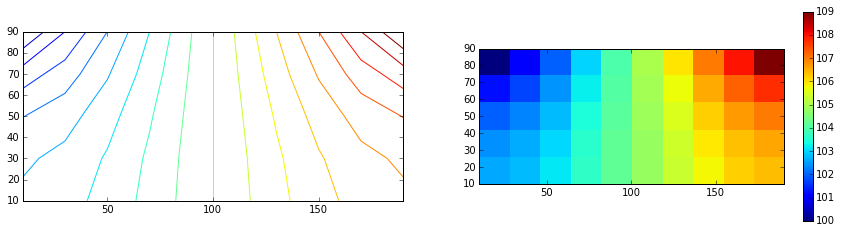

In [20]:
#Create a contour plot of heads
FIG = plt.figure(figsize=(15,15))

#setup contour levels and plot extent
LEVELS = np.arange(100, 109, 0.5)
EXTENT = (DELR/2., LX - DELR/2., DELC/2., LY - DELC/2.)
print 'Contour Levels: ', LEVELS
print 'Extent of domain: ', EXTENT

#Make a contour plot on the first axis
AX1 = FIG.add_subplot(1, 2, 1, aspect='equal')
AX1.contour(np.flipud(HEAD[0, :, :]), levels=LEVELS, extent=EXTENT)

#Make a color flood on the second axis
AX2 = FIG.add_subplot(1, 2, 2, aspect='equal')
cax = AX2.imshow(HEAD[0, :, :], extent=EXTENT, interpolation='nearest')
cbar = FIG.colorbar(cax, orientation='vertical', shrink=0.25)


Look at the bottom of the MODFLOW output file (ending with a *.list) and note the water balance reported. It's that simple, the model automates the calculation of the water budget so the modeler does not have to.

##Testing your Skills

1.  Experiment with horizontal grid resolution, model domain, and aquifer characteristics.  Rerun the model and post process to evaluate the effects.

2.  Advanced Python People:  Create a water budget for the problem within the iPython notebook. Compare it to that reported in the MODFLOW *.list file.